# Downstream Dataset Builder MultiDB

```bash
data/
  raw/mitdb/                 # 你刚下载好的 MITDB（.hea/.dat/.atr）
  downstream/mitdb/
    spec.yaml
    splits.json
    window5s/
    center5s/
    beat/
```

```yaml
dataset: mitdb
target_fs: 500
window_sec: 5
beat_pre_sec: 0.2
beat_post_sec: 0.4
label_scheme: AAMI5
split:
  seed: 42
  train: 0.7
  val: 0.1
  test: 0.2
normalization: per_window_zscore
lead_policy: first_lead
```


## Part 0: Imports & Global Config

In [1]:
from pathlib import Path
import json
import wfdb
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import resample_poly
from collections import Counter, defaultdict

In [2]:
# -----------------------------
# Global configuration (edit here)
# -----------------------------
# contains mitdb/, nsrdb/, incart/, qtdb/
RAW_ROOT = Path("../../scratch/physionet.org/files")
# OUT_ROOT = Path("data/downstream_multidb")  # outputs will be written here
OUT_ROOT = Path("../../scratch/data/downstream_multidb")  # outputs will be written here

TARGET_FS = 500
WINDOW_SEC = 5
BEAT_PRE_SEC = 0.2
BEAT_POST_SEC = 0.4

LEAD_POLICY = "first"  # for now: single-lead
LABEL_SCHEME = "AAMI5"  # start with AAMI5 for consistency

SEED = 42
TRAIN_RATIO = 0.7
VAL_RATIO = 0.1

OUT_ROOT.mkdir(parents=True, exist_ok=True)

## Part 1:

Define a single “spec” that all datasets must follow.

Store target sampling rate, window/beat definition, label scheme, and split ratios into a spec file.

In [3]:
spec = {
    "target_fs": TARGET_FS,
    "window_sec": WINDOW_SEC,
    "beat_pre_sec": BEAT_PRE_SEC,
    "beat_post_sec": BEAT_POST_SEC,
    "lead_policy": LEAD_POLICY,
    "label_scheme": LABEL_SCHEME,
    "split": {
        "seed": SEED,
        "train": TRAIN_RATIO,
        "val": VAL_RATIO,
        "test": 1 - TRAIN_RATIO - VAL_RATIO,
    },
    "normalization": "per_window_zscore",
    "variants": ["window5s", "center5s", "beat"],
    "output_format": "X/y/rec_id/pos per split",
}

spec_path = OUT_ROOT / "spec.yaml"
with open(spec_path, "w", encoding="utf-8") as f:
    for k, v in spec.items():
        f.write(f"{k}: {v}\n")

print("Saved:", spec_path)

Saved: ../../scratch/data/downstream_multidb/spec.yaml


## Part 2: Adapter

Use dataset adapters to hide dataset-specific details (lead naming, label naming, annotation format).

Each adapter implements: `list_records`, `read_signal`, `select_lead`, `read_annotations`, `map_labels`.

In [4]:
def resample_1d(x: np.ndarray, fs_in: int, fs_out: int) -> np.ndarray:
    if fs_in == fs_out:
        return x.astype(np.float32)
    g = np.gcd(fs_in, fs_out)
    up = fs_out // g
    down = fs_in // g
    return resample_poly(x, up, down).astype(np.float32)


def resample_positions(pos: np.ndarray, fs_in: int, fs_out: int) -> np.ndarray:
    scale = fs_out / fs_in
    return np.round(pos * scale).astype(np.int64)


def zscore_per_window(x: np.ndarray) -> np.ndarray:
    mu = float(np.mean(x))
    sd = float(np.std(x))
    if sd < 1e-8:
        return x * 0.0
    return (x - mu) / sd


def select_lead(sig: np.ndarray, lead_names: list, policy: str = "first") -> np.ndarray:
    # Extend later: "MLII_if_exists", "II_if_exists", etc.
    if policy == "first":
        return sig[:, 0].astype(np.float32), lead_names[0] if lead_names else "lead0"
    raise ValueError(f"Unknown lead policy: {policy}")

## Part 3: AAMI label mapping

In [5]:
AAMI_MAP = {
    "N": "N",
    "L": "N",
    "R": "N",
    "e": "N",
    "j": "N",
    "A": "S",
    "a": "S",
    "J": "S",
    "S": "S",
    "V": "V",
    "E": "V",
    "F": "F",
    "/": "Q",
    "f": "Q",
    "Q": "Q",
}
AAMI_CLASSES = ["N", "S", "V", "F", "Q"]
CLASS_TO_IDX = {c: i for i, c in enumerate(AAMI_CLASSES)}


def map_symbols_to_aami(symbols: np.ndarray):
    y = np.full((len(symbols),), -1, dtype=np.int64)
    for i, s in enumerate(symbols):
        if s in AAMI_MAP:
            y[i] = CLASS_TO_IDX[AAMI_MAP[s]]
    keep = y >= 0
    return y, keep

## Part

Verify raw dataset can be loaded reliably (signals + metadata + annotations)

For each dataset: list a few records, print fs & lead names, plot a short segment.

In [6]:
class BaseAdapter:
    name = "base"
    ann_ext = None  # e.g., "atr"

    def list_records(self, db_dir: Path):
        raise NotImplementedError

    def read_signal(self, db_dir: Path, rec: str):
        """Return sig [T,C], fs_in, lead_names(list[str])."""
        raise NotImplementedError

    def read_annotations(self, db_dir: Path, rec: str):
        """Return positions (sample idx at fs_in), raw_labels (symbols)."""
        raise NotImplementedError

    def map_labels(self, raw_labels: np.ndarray):
        """Return y_cls, keep_mask."""
        return map_symbols_to_aami(raw_labels)


class MITDBAdapter(BaseAdapter):
    name = "mitdb"
    ann_ext = "atr"

    def find_record_root(self, db_dir: Path) -> Path:
        # Find a directory that contains .hea files
        hea = list(db_dir.glob("*.hea"))
        if len(hea) > 0:
            return db_dir
        # Otherwise search recursively and pick the most common parent
        hea_files = sorted(db_dir.glob("**/*.hea"))
        if len(hea_files) == 0:
            raise RuntimeError(f"No .hea found under: {db_dir}")
        # Usually records live in a single directory (e.g., db_dir/1.0.0)
        parents = [p.parent for p in hea_files]
        # pick the parent directory with the most .hea files
        from collections import Counter

        best_parent, _ = Counter(parents).most_common(1)[0]
        return best_parent

    def list_records(self, db_dir: Path):
        root = self.find_record_root(db_dir)
        return sorted([p.stem for p in root.glob("*.hea")])

    def read_signal(self, db_dir: Path, rec: str):
        root = self.find_record_root(db_dir)
        r = wfdb.rdrecord(str(root / rec))
        sig = r.p_signal.astype(np.float32)
        fs = int(r.fs)
        lead_names = (
            list(r.sig_name)
            if hasattr(r, "sig_name")
            else [f"lead{i}" for i in range(sig.shape[1])]
        )
        return sig, fs, lead_names

    def read_annotations(self, db_dir: Path, rec: str):
        root = self.find_record_root(db_dir)
        ann = wfdb.rdann(str(root / rec), self.ann_ext)
        pos = np.asarray(ann.sample, dtype=np.int64)
        sym = np.asarray(ann.symbol)
        return pos, sym


# Templates (we will fix details based on your local file structure)
class NSRDBAdapter(MITDBAdapter):
    name = "nsrdb"
    ann_ext = "atr"


class INCARTAdapter(MITDBAdapter):
    name = "incartdb"
    ann_ext = "atr"


class QTDBAdapter(MITDBAdapter):
    name = "qtdb"
    ann_ext = (
        "atr"  # may differ depending on your QTDB layout; we'll verify by listing files
    )


=== mitdb ===
db_dir: ../../scratch/physionet.org/files/mitdb
num_records: 48
sample records: ['100', '101', '102', '103', '104']
record: 100
fs_in: 360 sig shape: (650000, 2)
lead_names: ['MLII', 'V5']
chosen lead: MLII


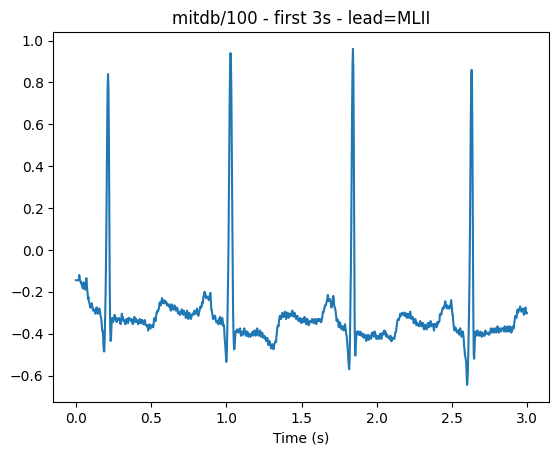

ann count: 2274 raw label examples: [np.str_('+'), np.str_('N'), np.str_('N'), np.str_('N'), np.str_('N'), np.str_('N'), np.str_('N'), np.str_('N'), np.str_('A'), np.str_('N')]
mapped beats: 2273 / 2274

=== nsrdb ===
db_dir: ../../scratch/physionet.org/files/nsrdb
num_records: 18
sample records: ['16265', '16272', '16273', '16420', '16483']
record: 16265
fs_in: 128 sig shape: (11730944, 2)
lead_names: ['ECG1', 'ECG2']
chosen lead: ECG1


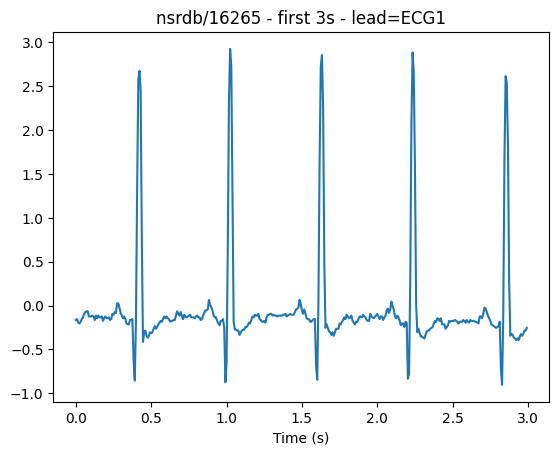

ann count: 100955 raw label examples: [np.str_('|'), np.str_('N'), np.str_('N'), np.str_('N'), np.str_('N'), np.str_('N'), np.str_('N'), np.str_('N'), np.str_('N'), np.str_('N')]
mapped beats: 100243 / 100955

=== incartdb ===
db_dir: ../../scratch/physionet.org/files/incartdb
num_records: 75
sample records: ['I01', 'I02', 'I03', 'I04', 'I05']
record: I01
fs_in: 257 sig shape: (462600, 12)
lead_names: ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
chosen lead: I


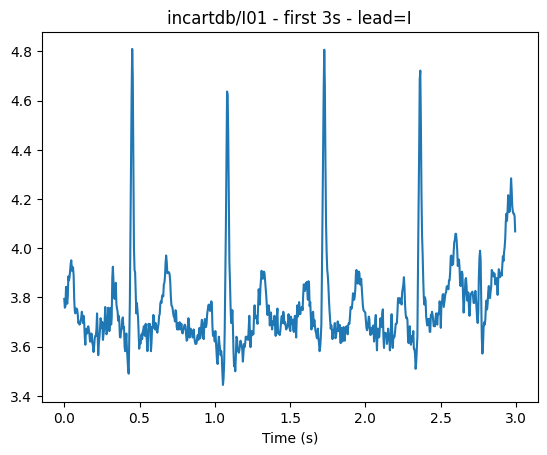

ann count: 2757 raw label examples: [np.str_('N'), np.str_('N'), np.str_('N'), np.str_('N'), np.str_('V'), np.str_('N'), np.str_('N'), np.str_('N'), np.str_('N'), np.str_('N')]
mapped beats: 2757 / 2757

=== qtdb ===
db_dir: ../../scratch/physionet.org/files/qtdb
num_records: 105
sample records: ['sel100', 'sel102', 'sel103', 'sel104', 'sel114']
record: sel100
fs_in: 250 sig shape: (225000, 2)
lead_names: ['MLII', 'V5']
chosen lead: MLII


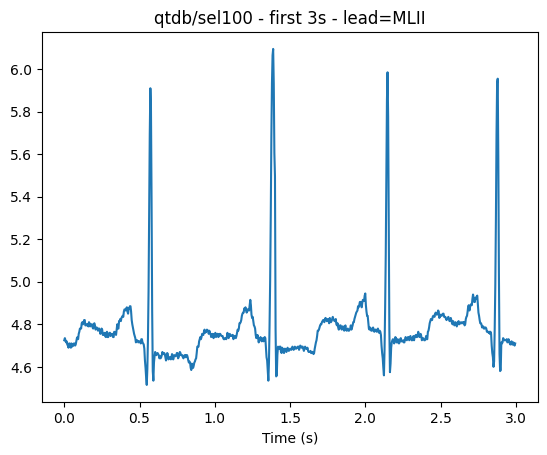

ann count: 1134 raw label examples: [np.str_('N'), np.str_('N'), np.str_('N'), np.str_('N'), np.str_('N'), np.str_('N'), np.str_('N'), np.str_('N'), np.str_('N'), np.str_('N')]
mapped beats: 1134 / 1134


In [7]:
ADAPTERS = {
    "mitdb": MITDBAdapter(),
    "nsrdb": NSRDBAdapter(),
    "incartdb": INCARTAdapter(),
    "qtdb": QTDBAdapter(),
}


def quick_probe_dataset(ds_name: str, n_plot_sec=3):
    adapter = ADAPTERS[ds_name]
    db_dir = RAW_ROOT / ds_name
    recs = adapter.list_records(db_dir)
    print(f"\n=== {ds_name} ===")
    print("db_dir:", db_dir)
    print("num_records:", len(recs))
    print("sample records:", recs[:5])

    rec = recs[0]
    sig, fs_in, lead_names = adapter.read_signal(db_dir, rec)
    x, chosen_lead = select_lead(sig, lead_names, LEAD_POLICY)

    print("record:", rec)
    print("fs_in:", fs_in, "sig shape:", sig.shape)
    print("lead_names:", lead_names)
    print("chosen lead:", chosen_lead)

    # plot
    L = min(len(x), n_plot_sec * fs_in)
    t = np.arange(L) / fs_in
    plt.figure()
    plt.plot(t, x[:L])
    plt.title(f"{ds_name}/{rec} - first {n_plot_sec}s - lead={chosen_lead}")
    plt.xlabel("Time (s)")
    plt.show()

    # annotations
    try:
        pos, raw = adapter.read_annotations(db_dir, rec)
        print("ann count:", len(pos), "raw label examples:", list(raw[:10]))
        # show mapped coverage
        y_cls, keep = adapter.map_labels(raw)
        print("mapped beats:", int(keep.sum()), "/", len(keep))
    except Exception as e:
        print("Annotation read failed:", repr(e))


for ds in ["mitdb", "nsrdb", "incartdb", "qtdb"]:
    quick_probe_dataset(ds)

## Part

Build three downstream dataset variants from raw ECG + annotations.

Use a shared builder that outputs X/y/rec_id/pos, then apply record-wise split.

In [8]:
def build_window_level(x_rs, rpeaks_rs, y_cls, fs, win_sec=5):
    L = int(win_sec * fs)
    T = len(x_rs)
    stride = L
    X, Y, POS = [], [], []
    for start in range(0, T - L + 1, stride):
        end = start + L
        mask = (rpeaks_rs >= start) & (rpeaks_rs < end)
        if not np.any(mask):
            continue
        labels = y_cls[mask]
        y = int(np.bincount(labels, minlength=len(AAMI_CLASSES)).argmax())
        seg = zscore_per_window(x_rs[start:end].copy())
        X.append(seg)
        Y.append(y)
        POS.append(start)
    if not X:
        return None, None, None
    return (
        np.stack(X).astype(np.float32),
        np.array(Y, np.int64),
        np.array(POS, np.int64),
    )


def build_center_window(x_rs, rpeaks_rs, y_cls, fs, win_sec=5):
    L = int(win_sec * fs)
    half = L // 2
    T = len(x_rs)
    X, Y, POS = [], [], []
    for rp, y in zip(rpeaks_rs, y_cls):
        start = int(rp - half)
        end = start + L
        if start < 0 or end > T:
            continue
        seg = zscore_per_window(x_rs[start:end].copy())
        X.append(seg)
        Y.append(int(y))
        POS.append(int(rp))
    if not X:
        return None, None, None
    return (
        np.stack(X).astype(np.float32),
        np.array(Y, np.int64),
        np.array(POS, np.int64),
    )


def build_beat_level(x_rs, rpeaks_rs, y_cls, fs, pre_sec=0.2, post_sec=0.4):
    pre = int(pre_sec * fs)
    post = int(post_sec * fs)
    L = pre + post
    T = len(x_rs)
    X, Y, POS = [], [], []
    for rp, y in zip(rpeaks_rs, y_cls):
        start = int(rp - pre)
        end = int(rp + post)
        if start < 0 or end > T:
            continue
        seg = x_rs[start:end].copy()
        if len(seg) != L:
            continue
        seg = zscore_per_window(seg)
        X.append(seg)
        Y.append(int(y))
        POS.append(int(rp))
    if not X:
        return None, None, None
    return (
        np.stack(X).astype(np.float32),
        np.array(Y, np.int64),
        np.array(POS, np.int64),
    )

In [9]:
def make_record_split(records, seed=42, train_ratio=0.7, val_ratio=0.1):
    rng = np.random.default_rng(seed)
    recs = list(records)
    rng.shuffle(recs)
    n = len(recs)
    n_train = int(round(n * train_ratio))
    n_val = int(round(n * val_ratio))
    train = recs[:n_train]
    val = recs[n_train : n_train + n_val]
    test = recs[n_train + n_val :]
    return train, val, test

In [10]:
def concat_parts(parts):
    X = np.concatenate([p[0] for p in parts], axis=0)
    y = np.concatenate([p[1] for p in parts], axis=0)
    rec_id = np.concatenate([p[2] for p in parts], axis=0)
    pos = np.concatenate([p[3] for p in parts], axis=0)
    return X, y, rec_id, pos


def build_dataset(ds_name: str, max_records=0):
    adapter = ADAPTERS[ds_name]
    db_dir = RAW_ROOT / ds_name
    records = adapter.list_records(db_dir)
    if max_records > 0:
        records = records[:max_records]

    # Save split (per dataset) — keep separate because record sets differ
    train_recs, val_recs, test_recs = make_record_split(
        records, SEED, TRAIN_RATIO, VAL_RATIO
    )
    split_path = OUT_ROOT / ds_name / "splits.json"
    (OUT_ROOT / ds_name).mkdir(parents=True, exist_ok=True)
    with open(split_path, "w", encoding="utf-8") as f:
        json.dump(
            {"train": train_recs, "val": val_recs, "test": test_recs, "seed": SEED},
            f,
            indent=2,
        )

    variants_parts = {"window5s": [], "center5s": [], "beat": []}
    unmapped_counter = Counter()

    for rec in records:
        sig, fs_in, lead_names = adapter.read_signal(db_dir, rec)
        x, chosen_lead = select_lead(sig, lead_names, LEAD_POLICY)

        pos, raw = adapter.read_annotations(db_dir, rec)
        y_cls, keep = adapter.map_labels(raw)

        # collect unmapped labels for reporting
        for s in raw[~keep]:
            unmapped_counter[s] += 1

        pos = pos[keep]
        y_cls = y_cls[keep]

        # resample
        x_rs = resample_1d(x, fs_in, TARGET_FS)
        pos_rs = resample_positions(pos, fs_in, TARGET_FS)

        # build 3 variants
        Xw, yw, pw = build_window_level(x_rs, pos_rs, y_cls, TARGET_FS, WINDOW_SEC)
        Xc, yc, pc = build_center_window(x_rs, pos_rs, y_cls, TARGET_FS, WINDOW_SEC)
        Xb, yb, pb = build_beat_level(
            x_rs, pos_rs, y_cls, TARGET_FS, BEAT_PRE_SEC, BEAT_POST_SEC
        )

        if Xw is not None:
            variants_parts["window5s"].append(
                (Xw, yw, np.array([rec] * len(yw), dtype=object), pw)
            )
        if Xc is not None:
            variants_parts["center5s"].append(
                (Xc, yc, np.array([rec] * len(yc), dtype=object), pc)
            )
        if Xb is not None:
            variants_parts["beat"].append(
                (Xb, yb, np.array([rec] * len(yb), dtype=object), pb)
            )

    # concat
    datasets = {}
    for v in ["window5s", "center5s", "beat"]:
        X, y, rec_id, pos = concat_parts(variants_parts[v])
        datasets[v] = (X, y, rec_id, pos)

    report = {
        "dataset": ds_name,
        "lead_policy": LEAD_POLICY,
        "target_fs": TARGET_FS,
        "chosen_label_scheme": LABEL_SCHEME,
        "unmapped_top20": unmapped_counter.most_common(20),
    }
    with open(OUT_ROOT / ds_name / "build_report.json", "w", encoding="utf-8") as f:
        json.dump(report, f, indent=2)

    return datasets

window5s (1083, 2500) (1083,) finite: True


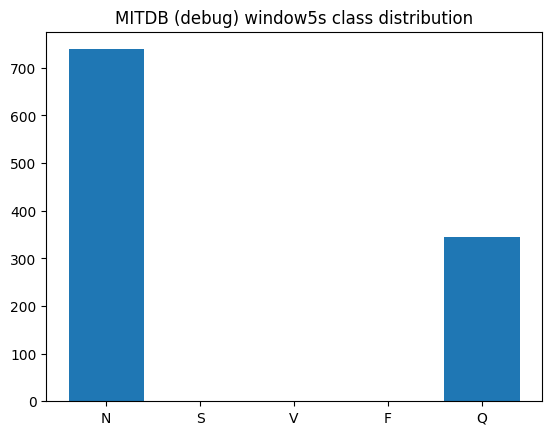

center5s (6307, 2500) (6307,) finite: True


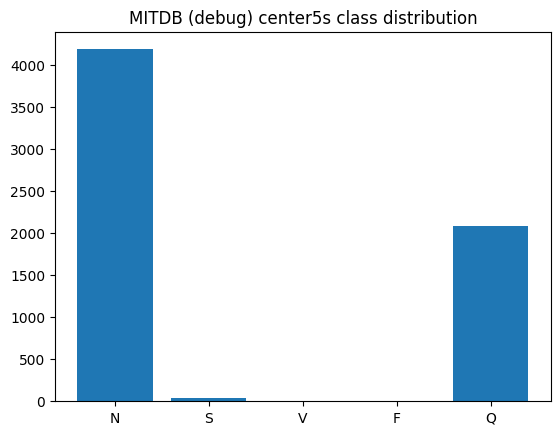

beat (6324, 300) (6324,) finite: True


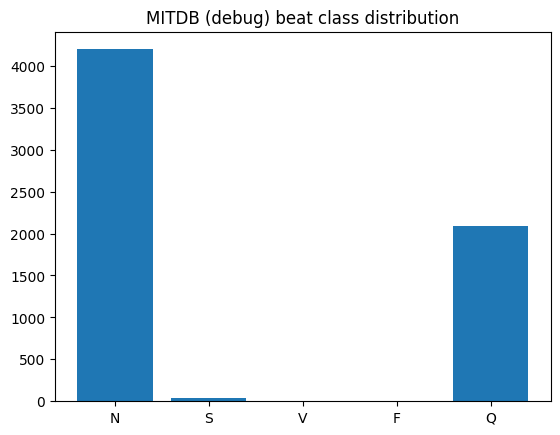

In [11]:
mitdb_data = build_dataset("mitdb", max_records=3)

for v, (X, y, rec_id, pos) in mitdb_data.items():
    print(v, X.shape, y.shape, "finite:", np.isfinite(X).all())
    counts = np.bincount(y, minlength=len(AAMI_CLASSES))
    plt.figure()
    plt.bar(range(len(AAMI_CLASSES)), counts)
    plt.xticks(range(len(AAMI_CLASSES)), AAMI_CLASSES)
    plt.title(f"MITDB (debug) {v} class distribution")
    plt.show()

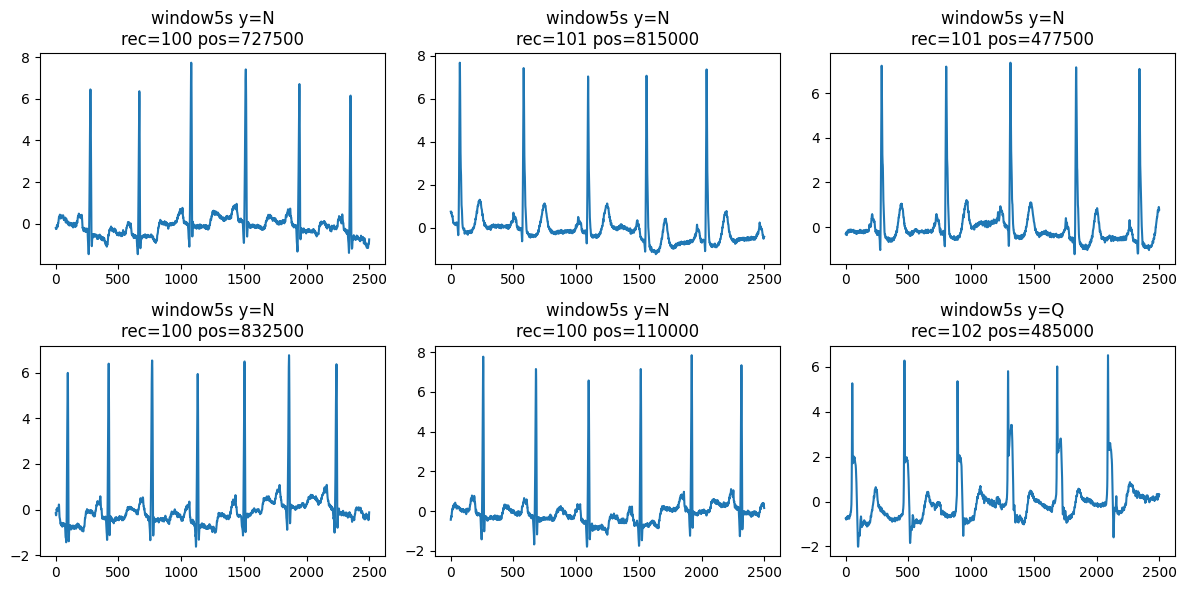

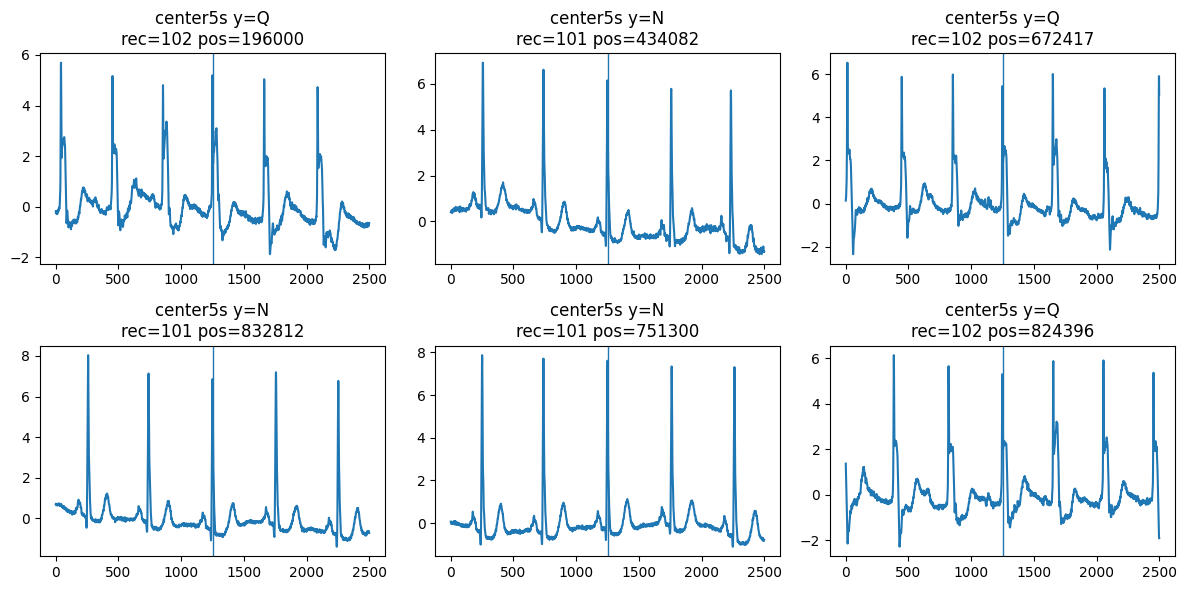

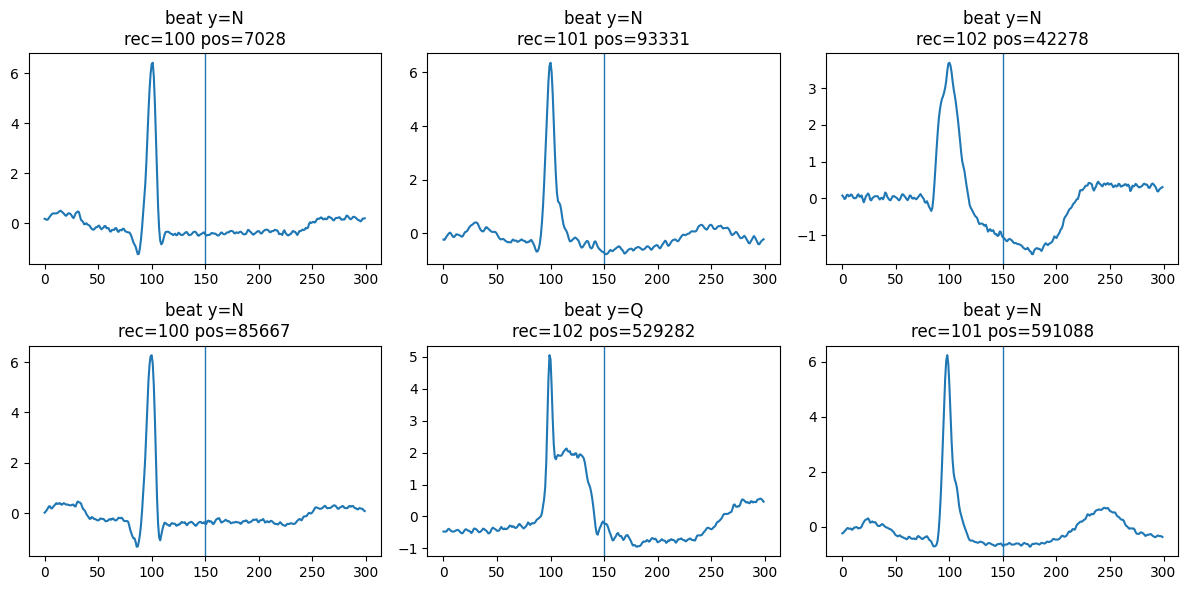

In [12]:
rng = np.random.default_rng(0)


def plot_samples(dataset_pack, variant, n=6):
    X, y, rec_id, pos = dataset_pack[variant]
    idx = rng.choice(len(X), size=min(n, len(X)), replace=False)
    plt.figure(figsize=(12, 6))
    for i, k in enumerate(idx, 1):
        plt.subplot(2, 3, i)
        plt.plot(X[k])
        plt.title(f"{variant} y={AAMI_CLASSES[y[k]]}\nrec={rec_id[k]} pos={pos[k]}")
        if variant in ["center5s", "beat"]:
            plt.axvline(len(X[k]) // 2, linewidth=1)
    plt.tight_layout()
    plt.show()


plot_samples(mitdb_data, "window5s")
plot_samples(mitdb_data, "center5s")
plot_samples(mitdb_data, "beat")

In [13]:
def split_by_records(X, y, rec_id, pos, split_recs):
    mask = np.isin(rec_id, np.array(split_recs, dtype=object))
    return X[mask], y[mask], rec_id[mask], pos[mask]


def save_variant_splits(ds_name, variant, pack, splits):
    out_dir = OUT_ROOT / ds_name / variant
    out_dir.mkdir(parents=True, exist_ok=True)
    X, y, rec_id, pos = pack

    for sp in ["train", "val", "test"]:
        Xs, ys, rs, ps = split_by_records(X, y, rec_id, pos, splits[sp])
        np.save(out_dir / f"X_{sp}.npy", Xs.astype(np.float32))
        np.save(out_dir / f"y_{sp}.npy", ys.astype(np.int64))
        np.save(out_dir / f"rec_id_{sp}.npy", rs)
        np.save(out_dir / f"pos_{sp}.npy", ps.astype(np.int64))

        counts = np.bincount(ys, minlength=len(AAMI_CLASSES)).tolist()
        print(f"{ds_name}/{variant}/{sp}: X={Xs.shape} counts={counts}")


def load_splits(ds_name):
    with open(OUT_ROOT / ds_name / "splits.json", "r", encoding="utf-8") as f:
        return json.load(f)

In [14]:
ALL_DATASETS = ["mitdb", "nsrdb", "incartdb"]

built = {}
for ds in ALL_DATASETS:
    print("\n==============================")
    print("Building:", ds)
    data_pack = build_dataset(ds, max_records=0)  # full
    splits = load_splits(ds)

    for variant in ["window5s", "center5s", "beat"]:
        save_variant_splits(ds, variant, data_pack[variant], splits)

    built[ds] = data_pack

print("\nAll done.")


Building: mitdb
mitdb/window5s/train: X=(12249, 2500) counts=[10878, 347, 312, 1, 711]
mitdb/window5s/val: X=(1805, 2500) counts=[1792, 7, 6, 0, 0]
mitdb/window5s/test: X=(3249, 2500) counts=[2584, 1, 10, 4, 650]
mitdb/center5s/train: X=(77640, 2500) counts=[64705, 2644, 5733, 416, 4142]
mitdb/center5s/val: X=(11622, 2500) counts=[11333, 70, 213, 6, 0]
mitdb/center5s/test: X=(19923, 2500) counts=[14334, 60, 1274, 379, 3876]
mitdb/beat/train: X=(77833, 300) counts=[64865, 2651, 5746, 417, 4154]
mitdb/beat/val: X=(11652, 300) counts=[11363, 70, 213, 6, 0]
mitdb/beat/test: X=(19975, 300) counts=[14372, 60, 1276, 379, 3888]

Building: nsrdb
nsrdb/window5s/train: X=(200597, 2500) counts=[200597, 0, 0, 0, 0]
nsrdb/window5s/val: X=(29662, 2500) counts=[29662, 0, 0, 0, 0]
nsrdb/window5s/test: X=(45908, 2500) counts=[45908, 0, 0, 0, 0]
nsrdb/center5s/train: X=(1277563, 2500) counts=[1277451, 83, 21, 8, 0]
nsrdb/center5s/val: X=(179436, 2500) counts=[179426, 7, 3, 0, 0]
nsrdb/center5s/test: X=(